<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/lstm_ae_(1_layer)_UCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import re
import time
import tensorflow as tf
from tensorflow import keras

# Read Data

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':"1lgLKtSn-yDX2-nK19PpMp9xB-MatUUFX"})
downloaded.GetContentFile('splice.data', mimetype=None)  

In [6]:
def convert_label(row):
  if row["Classes"] == 'EI':
    return 0
  if row["Classes"] == 'IE':
    return 1
  if row["Classes"] == 'N':
    return 2

In [32]:
splice_df = pd.read_csv('splice.data', header=None)
splice_df.columns = ['Classes', 'Name', 'Seq']
splice_df["Seq"] = splice_df["Seq"].str.replace(' ', '').str.replace('N', 'A').str.replace('D', 'T').str.replace('S', 'C').str.replace('R', 'G')
splice_df["Label"] = splice_df.apply(lambda row: convert_label(row), axis=1)
print('The shape of the datasize is', splice_df.shape)
splice_df.head()

The shape of the datasize is (3190, 4)


,Classes,Name,Seq,Label
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,0
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,0
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,0
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,0
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,0


In [33]:
seq_num = 0
for seq in splice_df["Seq"]:
  char_num = 0
  for char in seq:
    if char != 'A' and char != 'C' and char != 'T' and char != 'G':
      print("seq", seq_num, 'char', char_num, 'is', char)
    char_num += 1
  seq_num += 1

In [34]:
# check if the length of the sequence is the same 
seq_len = len(splice_df.Seq[0])
print("The length of the sequence is", seq_len)
for seq in splice_df.Seq[:200]:
  assert len(seq) == seq_len

The length of the sequence is 60


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
xtrain_full, xtest, ytrain_full, ytest = train_test_split(splice_df, splice_df.Label, test_size=0.2, random_state=100, stratify=splice_df.Label)
xtrain, xval, ytrain, yval = train_test_split(xtrain_full, ytrain_full, test_size=0.2, random_state=100, stratify=ytrain_full)
print("shape of training, validation, test set\n", xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape)

shape of training, validation, test set
 (2041, 4) (511, 4) (638, 4) (2041,) (511,) (638,)


In [36]:
word_size = 1
vocab = [''.join(p) for p in product('ACGT', repeat=word_size)]
word_to_idx = {word: i for i, word in enumerate(vocab)}
vocab_size = len(word_to_idx)
print('vocab_size:', vocab_size)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 4


In [37]:
# the first two index of TextVectorization has been reserved to EOS and OOV
def index_preprocess(x):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, x_index

In [38]:
# not sure the correct way to get mapping from word to its index
create1gram('A C G T') - 2

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 2, 1, 0])>

In [39]:
xtrain_seq = tf.data.Dataset.from_tensor_slices(xtrain['Seq']).map(index_preprocess).batch(32)
xval_seq = tf.data.Dataset.from_tensor_slices(xval['Seq']).map(index_preprocess).batch(32)
xtest_seq = tf.data.Dataset.from_tensor_slices(xtest['Seq']).map(index_preprocess).batch(32)

In [50]:
latent_size = 30

encoder = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, latent_size),
    keras.layers.LSTM(latent_size, return_sequences=False),
])

decoder = keras.Sequential([
    keras.layers.RepeatVector(seq_len, input_shape=[latent_size]),
    keras.layers.LSTM(latent_size, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(4, activation='softmax'))  # ACTGN
])

recurrent_ae = keras.Sequential([encoder, decoder])
recurrent_ae.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_14 (Sequential)   (None, 30)                9120      
_________________________________________________________________
sequential_15 (Sequential)   (None, 60, 4)             7444      
Total params: 16,564
Trainable params: 16,564
Non-trainable params: 0
_________________________________________________________________


In [53]:
recurrent_ae.compile(optimizer='adam', \
        loss='sparse_categorical_crossentropy', metrics='accuracy')
es_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
ae_hist = recurrent_ae.fit(xtrain_seq, validation_data=xval_seq, epochs=600, callbacks=[es_cb])

Epoch 1/600
64/64 [==============================] - 4s 65ms/step - loss: 1.1172 - accuracy: 0.4902 - val_loss: 1.0989 - val_accuracy: 0.5000
Epoch 2/600
64/64 [==============================] - 4s 56ms/step - loss: 1.0783 - accuracy: 0.5073 - val_loss: 1.0853 - val_accuracy: 0.5080
Epoch 3/600
64/64 [==============================] - 4s 56ms/step - loss: 1.0748 - accuracy: 0.5088 - val_loss: 1.0855 - val_accuracy: 0.5061
Epoch 4/600
64/64 [==============================] - 4s 56ms/step - loss: 1.0748 - accuracy: 0.5100 - val_loss: 1.0833 - val_accuracy: 0.5074
Epoch 5/600
64/64 [==============================] - 4s 59ms/step - loss: 1.0741 - accuracy: 0.5103 - val_loss: 1.0819 - val_accuracy: 0.5082
Epoch 6/600
64/64 [==============================] - 4s 60ms/step - loss: 1.0735 - accuracy: 0.5109 - val_loss: 1.0815 - val_accuracy: 0.5088
Epoch 7/600
64/64 [==============================] - 4s 56ms/step - loss: 1.0731 - accuracy: 0.5112 - val_loss: 1.0811 - val_accuracy: 0.5091
Epoch 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# # save model, there seems to be more room for the lstm ae to improve
# path = '/content/gdrive/My Drive/'
# recurrent_ae.save(path + 'lstm_ae_1.h5')

NameError: ignored

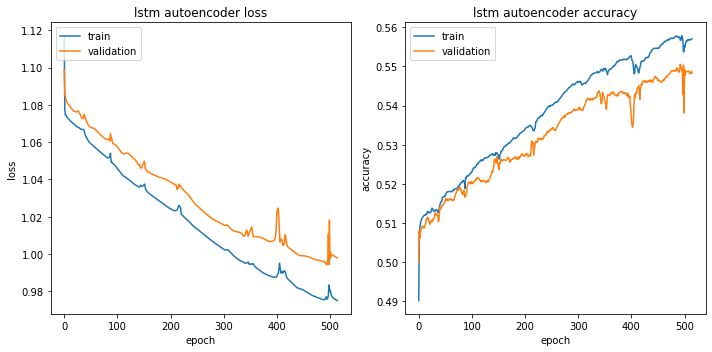

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(ae_hist.history['loss'], label='training')
  ax1.plot(ae_hist.history['val_loss'], label='validation')
  ax1.set_title('lstm autoencoder loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(ae_hist.history['accuracy'], label='training')
  ax2.plot(ae_hist.history['val_accuracy'], label='validation')
  ax2.set_title('lstm autoencoder accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [55]:
# how to reconstruct the sequence
idx_to_char = {'0':'T', '1':'G', '2':'C', '3':'A'}
def show_reconstructions(model, x_seq=xtrain_seq, original_data=xtrain, samples=10):
  reconstructions = recurrent_ae.predict(x_seq)
  print('The shape of reconstructions', reconstructions.shape)
  recon_softmax = np.argmax(reconstructions, axis=-1)
  for i in range(samples):
    seq = ''
    for idx in recon_softmax[i]:
      seq += idx_to_char[str(idx)]
    print()
    print('The {}-th original sequence vs after reconstruction'.format(i))
    print(original_data['Seq'].iloc[i])
    print(seq)

show_reconstructions(recurrent_ae, xval_seq, xval)

The shape of reconstructions (511, 60, 4)

The 0-th original sequence vs after reconstruction
AAGGGAGTGGCTTCCTCTCTGCCTCTGTGCCCACTGACATGTAGGGGAGAGGGGAAGATG
GGGGGGGGGCCCCCCCTTTTTTTTTTTGCCCCCAAAAATTTTGGGGGGGGGGGGGGAAGG

The 1-th original sequence vs after reconstruction
GACACTGAGTAGGACCTCCAACTCTTACAGATCCCTTCCCCTGAAGTATTTGAAGAGCTG
TCCCCCCGGAAAAACCCCCCCCCCCCCCAGGCCCCCCCCCTAAAAATTTTTGAAAAGCTG

The 2-th original sequence vs after reconstruction
GATCTACTGTCTAATATCTTAAGGGCTTAGTATTTTTCTCAGTGACTTTGTGGGTTCTTT
AATTTTTTTTTTTTTTTTTTTTTAATTTAAGTTTTTTTTTAAAAATTTTTGGGGTTTTTT

The 3-th original sequence vs after reconstruction
AAAGCAGATCAGCTGTATAAACAGAAAATTATTCGTGGTTTCTGTCACTTGTGTGATGGT
AAAAAAAAAAAGGGTTTTAAAAAAAAAACTTTTTGTTTTTTTTCCCCTTTTTTGGAAGGT

The 4-th original sequence vs after reconstruction
AAGACCAGGTGGCTCCATGCCTTTCCCCAGGTTCTGGAGATGAGCATTGGGGCGCCGGAA
AAAAAACCGGGGGGGCCCCCCCCCCCCCAGGTTTGGGGGGGAAACCCGGGGGCCCCGGAA

The 5-th original sequence vs after reconstruction
ATGCTGACCACTTCCCTCTTCTCTGAGCAGTGTGAC

In [56]:
xtrain_vec = encoder.predict(xtrain_seq)
xval_vec = encoder.predict(xval_seq)
xtest_vec = encoder.predict(xtest_seq)
print('The shape of xtrain/xval/xtest_seq is', xtrain_vec.shape, xval_vec.shape, xtest_vec.shape)

The shape of xtrain/xval/xtest_seq is (2041, 30) (511, 30) (638, 30)


In [57]:
def plotVec(ax, x, y, title="title"):
  scatter = ax.scatter(x[:, 0], x[:, 1], c=y, 
             cmap=matplotlib.colors.ListedColormap(["red", "blue", "yellow"]))
  ax.set_title(title)
  ax.legend(*scatter.legend_elements(), loc=0, title="Classes")

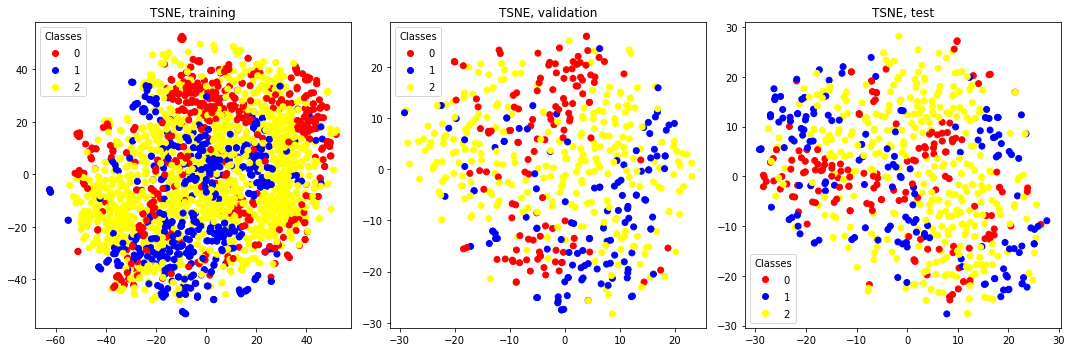

In [58]:
xtrain_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtrain_vec)
xval_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xval_vec)
xtest_tsne = TSNE(n_components=2, metric="cosine").fit_transform(xtest_vec)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plotVec(axes[0], xtrain_tsne, ytrain, title="TSNE, training")
plotVec(axes[1], xval_tsne, yval, title="TSNE, validation")
plotVec(axes[2], xtest_tsne, ytest, title="TSNE, test")
fig.tight_layout()

In [59]:
model = keras.models.Sequential([
  keras.layers.Dense(128, activation="relu", input_shape=[latent_size]),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(64, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(32, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(16, activation="relu"), 
  keras.layers.Dropout(0.2),    
  keras.layers.Dense(3, activation="softmax")                               
])
model.compile(keras.optimizers.SGD(momentum=0.9), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [60]:
model_hist = model.fit(xtrain_vec, ytrain, validation_data=(xval_vec, yval), epochs=50, callbacks=[es_cb])

Epoch 1/50
64/64 [==============================] - 0s 4ms/step - loss: 1.0353 - accuracy: 0.5096 - val_loss: 1.0192 - val_accuracy: 0.5186
Epoch 2/50
64/64 [==============================] - 0s 2ms/step - loss: 1.0115 - accuracy: 0.5189 - val_loss: 0.9878 - val_accuracy: 0.5186
Epoch 3/50
64/64 [==============================] - 0s 2ms/step - loss: 0.9635 - accuracy: 0.5380 - val_loss: 0.8867 - val_accuracy: 0.5382
Epoch 4/50
64/64 [==============================] - 0s 2ms/step - loss: 0.8861 - accuracy: 0.5879 - val_loss: 0.7338 - val_accuracy: 0.6908
Epoch 5/50
64/64 [==============================] - 0s 2ms/step - loss: 0.7433 - accuracy: 0.6663 - val_loss: 0.6239 - val_accuracy: 0.7750
Epoch 6/50
64/64 [==============================] - 0s 2ms/step - loss: 0.6370 - accuracy: 0.7300 - val_loss: 0.4873 - val_accuracy: 0.8415
Epoch 7/50
64/64 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.7825 - val_loss: 0.3762 - val_accuracy: 0.8767
Epoch 8/50
64/64 [==

In [23]:
def eval_model(model, x, true_label, ds_name="Training"):
  loss, acc = model.evaluate(x, true_label, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}".format(ds_name, np.round(loss, 3), np.round(acc, 3)))

In [61]:
eval_model(model, xtrain_vec, ytrain, "Training")
eval_model(model, xval_vec, yval, "Validation")
eval_model(model, xtest_vec, ytest, "Test")

Training Dataset: loss = 0.232 and acccuracy = 0.915
Validation Dataset: loss = 0.321 and acccuracy = 0.898
Test Dataset: loss = 0.247 and acccuracy = 0.911


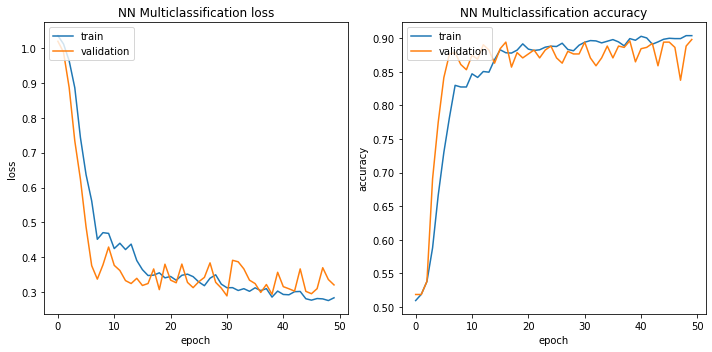

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(model_hist.history['loss'], label='training')
  ax1.plot(model_hist.history['val_loss'], label='validation')
  ax1.set_title('NN Multiclassification loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(model_hist.history['accuracy'], label='training')
  ax2.plot(model_hist.history['val_accuracy'], label='validation')
  ax2.set_title('NN Multiclassification accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [ ]:
# def n_gram(x, word_size=3):
#   arr_x = [c for c in x]
#   words = tf.strings.ngrams(arr_x, ngram_width=word_size, separator='').numpy()
#   words = list(pd.Series(words).apply(lambda b: b.decode('utf-8')))
#   return words

# def construct_sentence(words):
#   sentence = ' '.join(words)
#   return sentence

In [ ]:
# word_size = 3
# splice_df["ngram"] = splice_df.apply(lambda df: n_gram(df["Seq"], word_size), axis=1)
# splice_df["sentence"] = splice_df["ngram"].apply(construct_sentence)
# splice_df.head()

In [ ]:
# for sentence in splice_df["ngram"][:5]:
#   print(len(sentence))

58
58
58
58
58
